In [1]:
from SimPEG import DC, IP
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
%pylab inline
from matplotlib import colors
from simpegEMIP.SeogiUtils.View import Circle2D
import h5py
from pylab import cm
from matplotlib import gridspec

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interactive', 'Text', 'Button', 'Widget']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
work_dir = "../data/"
fname = 'output_simulation_sip.h5'
output_simulation = h5py.File(work_dir+fname, 'r')
geology_names = np.array(["background", "overburden","porphyry", "stock", "halo", "clay", "mineralization"], dtype=str),    

In [3]:
mesh = Mesh.TensorMesh.readUBC(work_dir+output_simulation['mesh_name'].value)
sigma = output_simulation['sigma'].value
eta = output_simulation['eta'].value
tau = output_simulation['tau'].value
c = output_simulation['c'].value

In [4]:
fname = 'output_dc_inversion.h5'
output_dc_inversion = h5py.File(work_dir+fname, 'r')

In [5]:
IO_3d = DC.IO()
survey_3d = IO_3d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value,
    b_locations=output_simulation['b_locations'].value,
    m_locations=output_simulation['m_locations'].value,
    n_locations=output_simulation['n_locations'].value,
    data_dc=output_simulation['dc_data'].value,
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value,    
    data_sip_type='volt',
    line_inds = output_simulation['line_inds'].value,
    dimension=3
)
mesh_3d, actind = IO_3d.set_mesh(dx=25., dy=50., dz=15., dimension=3)
actind = np.ones(mesh_3d.nC, dtype='bool')
actMap = Maps.InjectActiveCells(mesh_3d, actind, valInactive=0.)
survey_3d_ip = IP.from_dc_to_ip_survey(dc_survey=survey_3d, dim='3D')
problem_ip = IP.Problem3D_N(
    mesh_3d, etaMap=actMap,
    storeJ=False,
    Solver=PardisoSolver,
    sigma=output_dc_inversion['sigma'].value,
    verbose=False,
    data_type='apparent_chargeability'
)
problem_ip.pair(survey_3d_ip)
core_3d_inds, mesh_3d_core = Utils.ExtractCoreMesh(IO_3d.xyzlim, mesh_3d)

/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:229: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


In [6]:
dobs = IO_3d.voltages_sip[:,-1] / IO_3d.voltages

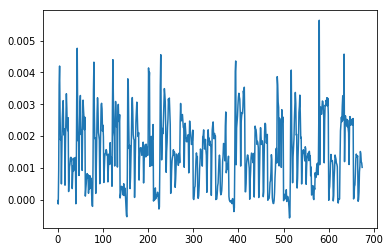

In [7]:
plt.plot(dobs)

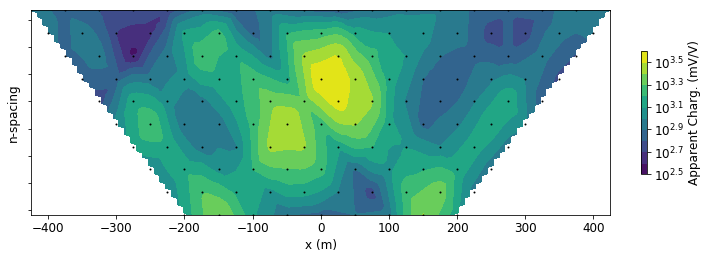

In [8]:
IO_3d.plotPseudoSection(data=IO_3d.data_dc/IO_3d.G, scale='log', data_type='apparent_chargeability', iline=2)

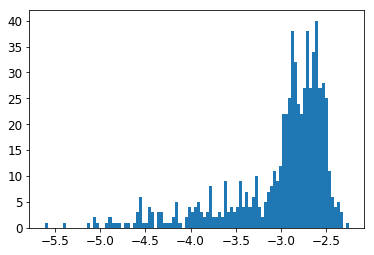

In [9]:
out = hist(np.log10(abs(dobs)), bins=100)

In [10]:
survey_3d_ip.dobs = dobs.copy()
m0_ip = np.ones(mesh_3d.nC)*1e-5
mopt_ip, pred_ip = IP.run_inversion(
    m0_ip, survey_3d_ip, actind, mesh_3d, 0.05, 10**-4,
    alpha_y=1., alpha_s=1, maxIter=15,
    lower=0., upper=1., use_sensitivity_weight=False
)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.30e+00  2.44e+04  0.00e+00  2.44e+04    1.32e+02      0              
   1  2.30e+00  2.98e+03  1.93e+02  3.43e+03    1.20e+02      0              
   2  4.60e-01  8.75e+02  3.46e+02  1.03e+03    1.14e+02      0   Skip BFGS  
   3  4.60e-01  4.39e+02  4.27e+02  6.36e+02    1.17e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.4369e+03
1 : |xc-x_last| = 1.3315e-02 <= to

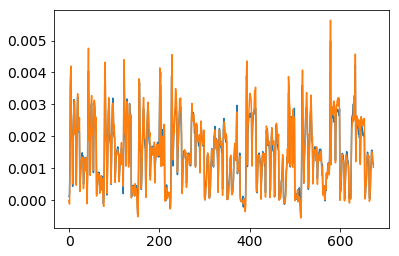

In [14]:
plt.plot((pred_ip))
plt.plot((survey_3d_ip.dobs))

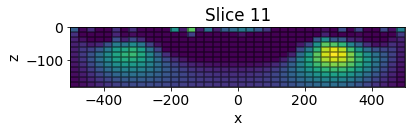

In [15]:
mesh_3d_core.plotSlice(mopt_ip[core_3d_inds], normal='Y', grid=True)
plt.gca().set_aspect(1)

In [16]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
sigma_est = sigmaMap * mopt_dc
yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -70
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])
vmin, vmax = 300, 5000.
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
ax2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cbaxes = fig.add_axes([0.98, 0.35, 0.02, 0.3]) 
cb=plt.colorbar(
    out[0], cax=cbaxes, orientation="vertical", ax=ax1, ticks=[300, 1000., 5000.]
)

cb.set_ticklabels(np.array([300, 1000., 5000.], dtype=int))
cb.set_label("Resistivity ($\Omega$m)")
for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
#     ax.set_ylim(-500, 500)    
plt.tight_layout()


NameError: name 'sigmaMap' is not defined

In [12]:
!rm -f output_dc_inversion.h5

In [13]:
import h5py
mesh_name = 'mesh_3d_dc.txt'
mesh_3d.writeUBC(mesh_name)
output_dc_inversion = {
    'mesh_name': mesh_name,
    'sigma': sigma_est,
    'dc_data': survey_3d.dobs,
    'dc_data_pred': pred_dc
}
def save_dict_to_hdf5(fname, dictionary):
    """
    Save a dictionary to hdf5
    """
    f = h5py.File(fname, "w")
    for key in dictionary.keys():
        dset = f.create_dataset(key, data=dictionary[key])
    f.close()
save_dict_to_hdf5('output_dc_inversion.h5', output_dc_inversion)